# Project ARI3205 Interpretable AI for Deep Learning Models *(Jupyter Notebook #2)*
---

**Name:** Andrea Filiberto Lucas  
**ID No:** 0279704L

---

## Importing Necessary Libraries

In [25]:
# Check and install required libraries from the libraries.json file
import json

# Read the libraries from the text file
with open('lib.json', 'r') as file:
    libraries = json.load(file)

# ANSI escape codes for colored output
GREEN = "\033[92m"  # Green text
RED = "\033[91m"    # Red text
RESET = "\033[0m"   # Reset to default color

# Function to check and install libraries
def check_and_install_libraries(libraries):
    for lib, import_name in libraries.items():
        try:
            # Attempt to import the library
            __import__(import_name)
            print(f"[{GREEN}✔{RESET}] Library '{lib}' is already installed.")
        except ImportError:
            # If import fails, try to install the library
            print(f"[{RED}✖{RESET}] Library '{lib}' is not installed. Installing...")
            %pip install {lib}

# Execute the function to check and install libraries
check_and_install_libraries(libraries)

# Import necessary libraries for data analysis and modeling
import warnings                                                                     # Disable warnings
import pandas as pd                                                                 # Data manipulation and analysis                #type: ignore
import numpy as np                                                                  # Numerical computations                        #type: ignore
import matplotlib.pyplot as plt                                                     # Data visualization                            #type: ignore
import seaborn as sns                                                               # Statistical data visualization                #type: ignore
import statsmodels.formula.api as smf                                               # Statistical models                            #type: ignore
from sklearn.model_selection import train_test_split                                # Train-test split                              #type: ignore
from tensorflow.keras.models import Sequential                                      # Neural network model                          #type: ignore
from tensorflow.keras.layers import Dense, Input                                    # Neural network layers                         #type: ignore                                                               
from tensorflow.keras.optimizers import Adam                                        # Neural network optimizer                      #type: ignore
from sklearn.preprocessing import StandardScaler,  OneHotEncoder                    # Data scaling                                  #type: ignore
from sklearn.impute import SimpleImputer                                            # Missing value imputation                      #type: ignore
from sklearn.inspection import PartialDependenceDisplay, permutation_importance     # Feature importance                            #type: ignore
from sklearn.ensemble import RandomForestClassifier                                 # Random forest classifier                      #type: ignore
from sklearn.metrics import mean_squared_error                                      # Model evaluation                              #type: ignore
from alibi.explainers import ALE, plot_ale                                          # ALE plots                                     #type: ignore
from sklearn.neural_network import MLPClassifier                                    # Neural network classifier                     #type: ignore
from sklearn.metrics import accuracy_score                                          # Model evaluation                              #type: ignore
import statsmodels.api as sm                                                        # Statistical models                            #type: ignore

# Suppress specific warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names") 
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

[✔] Library 'tensorflow' is already installed.
[✔] Library 'scikit-learn' is already installed.
[✔] Library 'matplotlib' is already installed.
[✔] Library 'seaborn' is already installed.
[✔] Library 'pandas' is already installed.
[✔] Library 'numpy' is already installed.
[✔] Library 'scipy' is already installed.
[✔] Library 'alibi' is already installed.


## General Information on Titanic Dataset
*https://www.kaggle.com/competitions/titanic/data*

In [2]:
# Define the filenames
train_filename = 'Datasets/Titanic/train.csv'
test_filename = 'Datasets/Titanic/test.csv'
gender_submission_filename = 'Datasets/Titanic/gender_submission.csv'

# Load the datasets
try:
    train_data = pd.read_csv(train_filename)
    test_data = pd.read_csv(test_filename)
    gender_submission_data = pd.read_csv(gender_submission_filename)
    print(f"'{train_filename}' dataset loaded successfully.")
    print(f"'{test_filename}' dataset loaded successfully.")
    print(f"'{gender_submission_filename}' dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e.filename} was not found. Please ensure it is in the correct directory.")
    exit()
except pd.errors.EmptyDataError as e:
    print(f"Error: {e.filename} is empty.")
    exit()
except pd.errors.ParserError as e:
    print(f"Error: There was a problem parsing {e.filename}. Please check the file format.")
    exit()

# Dataset insights
print("\nTrain Dataset Overview:")
print(train_data.info())
print("\nTrain Dataset Statistical Summary:")
print(train_data.describe())

print("\nTest Dataset Overview:")
print(test_data.info())
print("\nTest Dataset Statistical Summary:")
print(test_data.describe())

print("\nGender Submission Dataset Overview:")
print(gender_submission_data.info())

'Datasets/Titanic/train.csv' dataset loaded successfully.
'Datasets/Titanic/test.csv' dataset loaded successfully.
'Datasets/Titanic/gender_submission.csv' dataset loaded successfully.

Train Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Train Dataset Statistical Su

## Feed-Forward Neural Network

In [3]:
# Load the Titanic dataset
train_data = pd.read_csv('Datasets/Titanic/train.csv')

# Preprocessing
# Separate features and target
y = train_data['Survived']  # Target
X = train_data.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])  # Features

# Handle categorical variables with one-hot encoding
categorical_features = ['Sex', 'Embarked']
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = one_hot_encoder.fit_transform(X[categorical_features])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and append the encoded columns
X = X.drop(columns=categorical_features)
X = pd.concat([X.reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (712, 11)
Test data shape: (179, 11)


In [4]:
# Build the feed-forward neural network
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define input shape explicitly
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5908 - loss: 0.6542 - val_accuracy: 0.8322 - val_loss: 0.5323
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7997 - loss: 0.5138 - val_accuracy: 0.8462 - val_loss: 0.4469
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8149 - loss: 0.4588 - val_accuracy: 0.8252 - val_loss: 0.4142
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7698 - loss: 0.4863 - val_accuracy: 0.8182 - val_loss: 0.4040
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7880 - loss: 0.4502 - val_accuracy: 0.8252 - val_loss: 0.4001
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8313 - loss: 0.4043 - val_accuracy: 0.8462 - val_loss: 0.3984
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8212 - loss: 0.4209 - val_accuracy: 0.8462 - val_loss: 0.3954
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8127 - loss: 0.4103 - val_accuracy: 0.8462 - val_los

## Surrogate Model - RFClassifier

In [5]:
# Train a surrogate model (RandomForestClassifier)
surrogate_model = RandomForestClassifier(random_state=42)
surrogate_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots

In [6]:
# Partial Dependence Plots (PDP) Function
def plot_pdp(surrogate_model, X_train, features_to_analyze):
    print("\nGenerating Partial Dependence Plots (PDP) for features:", features_to_analyze)
    fig, ax = plt.subplots(1, len(features_to_analyze), figsize=(15, 6), constrained_layout=True)
    for i, feature in enumerate(features_to_analyze):
        PartialDependenceDisplay.from_estimator(
            surrogate_model,  # The trained surrogate model (RandomForestClassifier)
            X_train,  # Training data
            features=[X_train.columns.get_loc(feature)],  # Single feature for PDP
            kind="average",  # PDP only
            ax=ax[i] if len(features_to_analyze) > 1 else ax,
            grid_resolution=50,
        )
        ax[i].set_title(f"PDP for {feature}")
    plt.show()

In [7]:
# Individual Conditional Expectation (ICE) Plots Function
def plot_ice(surrogate_model, X_train, features_to_analyze):
    print("\nGenerating Individual Conditional Expectation (ICE) Plots for features:", features_to_analyze)
    fig, ax = plt.subplots(1, len(features_to_analyze), figsize=(15, 6), constrained_layout=True)
    for i, feature in enumerate(features_to_analyze):
        PartialDependenceDisplay.from_estimator(
            surrogate_model,  # The trained surrogate model (RandomForestClassifier)
            X_train,  # Training data
            features=[X_train.columns.get_loc(feature)],  # Single feature for ICE
            kind="both",  # PDP and ICE
            ax=ax[i] if len(features_to_analyze) > 1 else ax,
            grid_resolution=50,
        )
        ax[i].set_title(f"ICE and PDP for {feature}")
    plt.show()

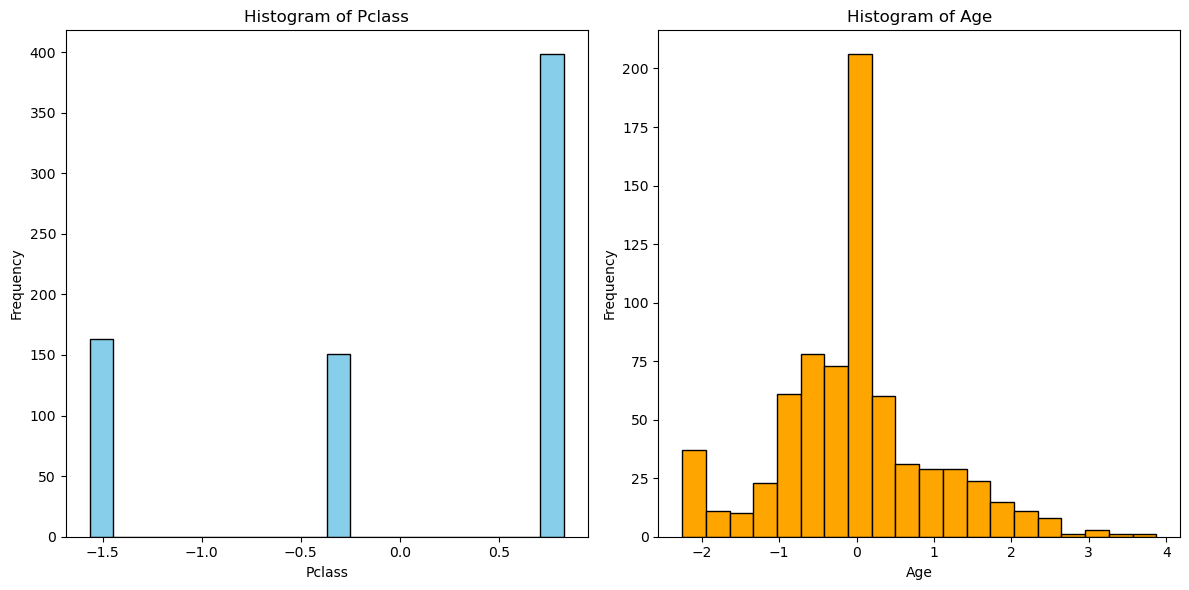


Generating Partial Dependence Plots (PDP) for features: ['Pclass', 'Age']


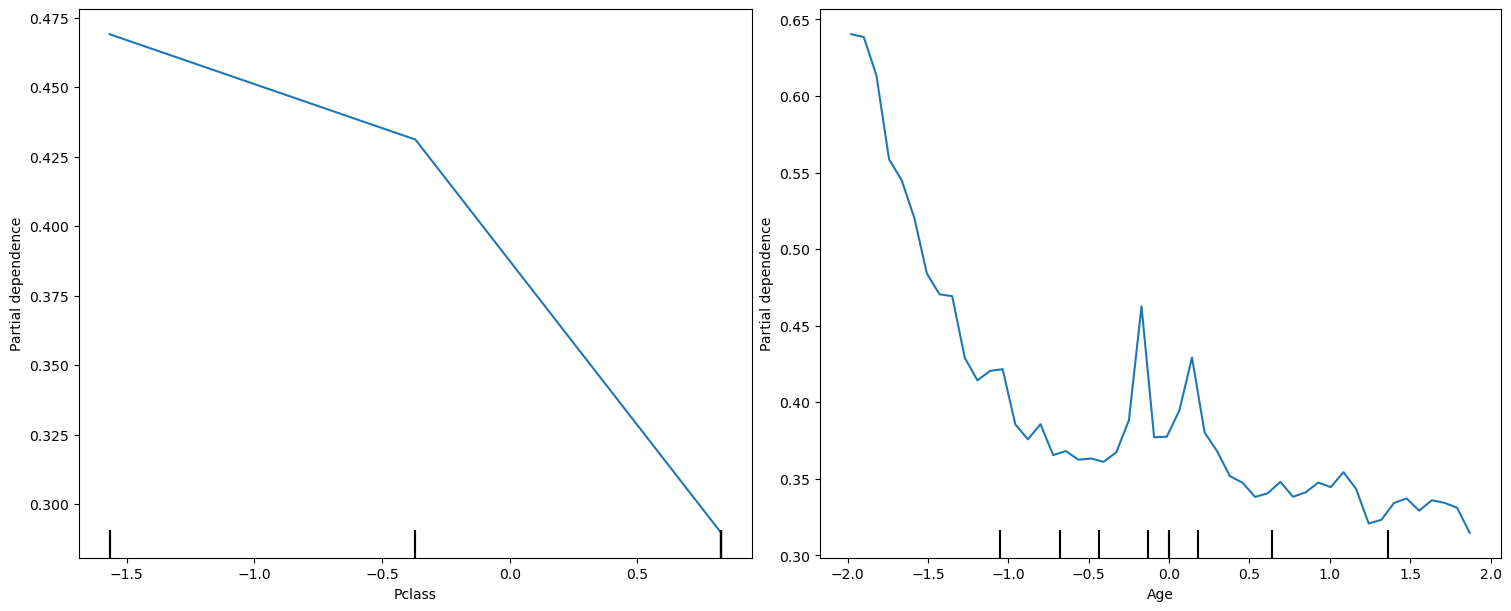


Generating Individual Conditional Expectation (ICE) Plots for features: ['Pclass', 'Age']


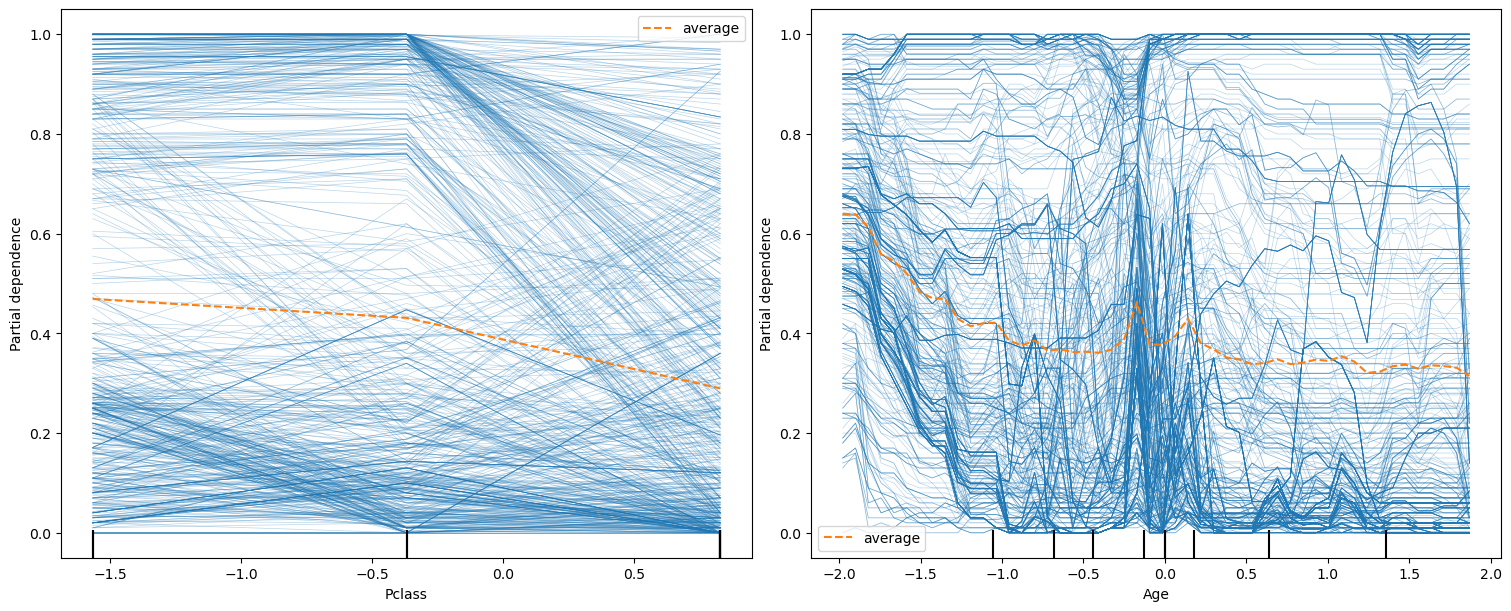

In [8]:
# Call PDP and ICE plot functions
features_to_analyze = ["Pclass", "Age"]

# Plot histograms for features_to_analyze
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_to_analyze):
    plt.subplot(1, len(features_to_analyze), i + 1)
    plt.hist(X_train[feature], bins=20, edgecolor='black', color='skyblue' if i % 2 == 0 else 'orange')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plot_pdp(surrogate_model, X_train, features_to_analyze)
plot_ice(surrogate_model, X_train, features_to_analyze)

## Permutation Feature Importance (PFI)

In [9]:
# Compute Permutation Feature Importance
def compute_pfi(model, X_test, y_test, feature_names):
    pfi_result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
    )

    # Convert PFI results into a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': pfi_result.importances_mean,
        'Std': pfi_result.importances_std
    })

    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nPermutation Feature Importance:\n", importance_df)
    return importance_df

In [10]:
# Plot Permutation Feature Importance as a Boxplot
def plot_pfi(model, X_test, y_test, feature_names):
    result = permutation_importance(
        model, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=[feature_names[i] for i in sorted_importances_idx]
    )

    ax = importances.plot.box(
        vert=False, whis=10, figsize=(12, 8),
        color=dict(boxes="blue", whiskers="black", medians="green", caps="black")
    )
    ax.axvline(x=0, color="k", linestyle="--")

    # Add faint grey lines across the graph for each feature
    for i in range(len(importances.columns)):
        plt.axhline(y=i + 1, color="grey", linestyle="-", linewidth=0.5, alpha=0.5)

    # Add faint grey lines upwards from the x-axis ticks
    xticks = ax.get_xticks()
    for tick in xticks:
        plt.axvline(x=tick, color="grey", linestyle="-", linewidth=0.5, alpha=0.5)
    
    # Set the x-axis limits
    ax.set_xlim(left=0 - 0.1 * (ax.get_xlim()[1] - 0))

    # Set the x-axis limits
    ax.set_xlabel("Decrease in Accuracy")
    ax.set_ylabel("Feature")
    ax.set_title("Permutation Feature Importance")
    plt.tight_layout()
    plt.show()


Permutation Feature Importance:
          Feature  Importance       Std
0         Pclass    0.070950  0.011463
4           Fare    0.050279  0.019672
5     Sex_female    0.046369  0.010615
1            Age    0.032961  0.019425
6       Sex_male    0.029609  0.008305
9     Embarked_S    0.015084  0.007516
2          SibSp    0.012849  0.008305
7     Embarked_C    0.010056  0.005474
3          Parch    0.009497  0.008305
10  Embarked_nan    0.000000  0.000000
8     Embarked_Q   -0.001117  0.003352


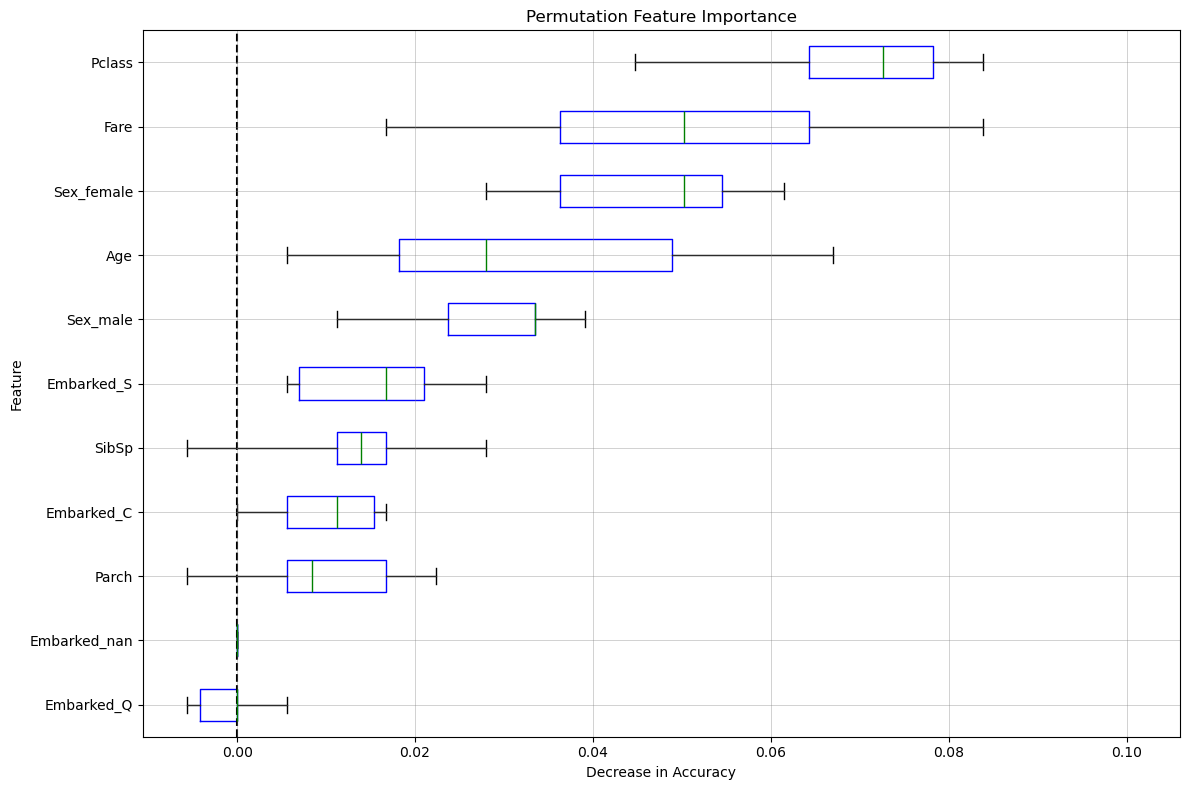

In [11]:
feature_names = X_test.columns
importance_df = compute_pfi(surrogate_model, X_test, y_test, feature_names)
plot_pfi(surrogate_model, X_test, y_test, feature_names)

## Accumulated Local Effects (ALE)

In [12]:
# Combine features and target for context if needed
data = pd.concat([X_train, y_train], axis=1)

# Define feature names
feature_names = X_train.columns

# Ensure valid input for ALE explainer
X_train_array = X_train.to_numpy()  # Convert to NumPy array to avoid warnings

# Create and compute ALE explainer
ale_explainer = ALE(surrogate_model.predict, feature_names=feature_names)
ale_explanation = ale_explainer.explain(X_train_array)

array([[<Axes: xlabel='Pclass', ylabel='ALE'>,
        <Axes: xlabel='Age', ylabel='ALE'>],
       [<Axes: xlabel='SibSp', ylabel='ALE'>,
        <Axes: xlabel='Parch', ylabel='ALE'>],
       [<Axes: xlabel='Fare', ylabel='ALE'>,
        <Axes: xlabel='Sex_female', ylabel='ALE'>],
       [<Axes: xlabel='Sex_male', ylabel='ALE'>,
        <Axes: xlabel='Embarked_C', ylabel='ALE'>],
       [<Axes: xlabel='Embarked_Q', ylabel='ALE'>,
        <Axes: xlabel='Embarked_S', ylabel='ALE'>],
       [<Axes: xlabel='Embarked_nan', ylabel='ALE'>, None]], dtype=object)

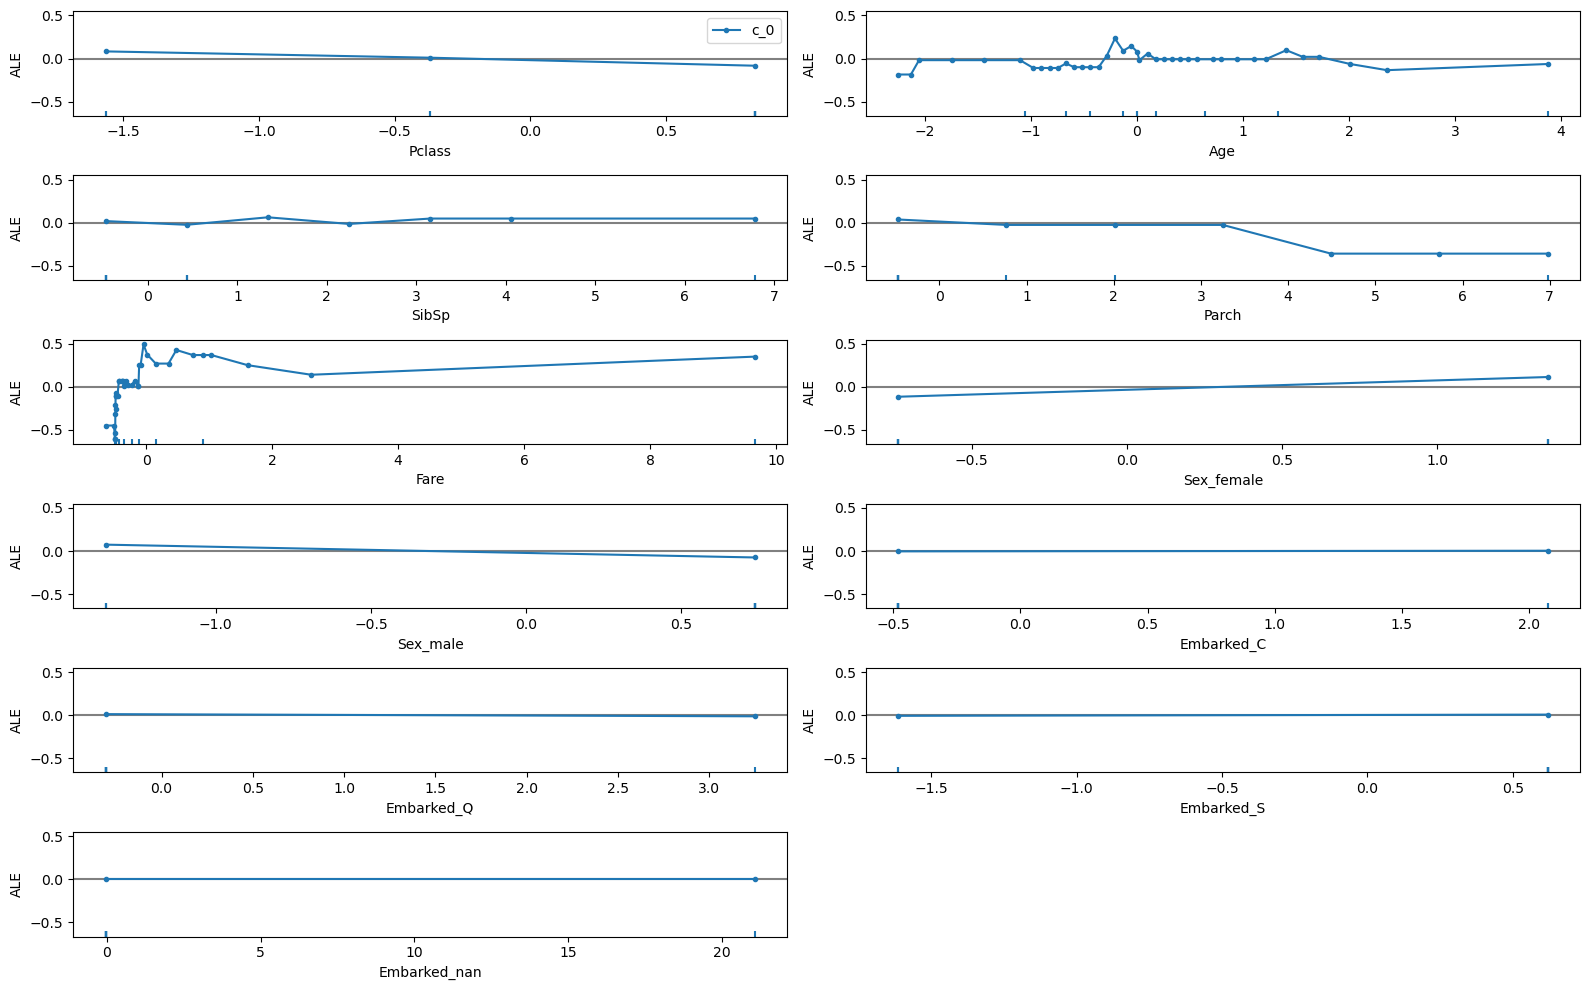

In [13]:
# Plot ALE for selected features
plot_ale(
    ale_explanation,
    features=feature_names.tolist(),  # Automatically include all features
    # features=["Pclass", "Age"],  # Select specific features
    n_cols=2,  # Arrange plots in 2 columns for better visualization
    fig_kw={'figwidth': 16, 'figheight': 10}  # Adjust figure size for clarity
)

## Global Surrogates

In [26]:
# Train an interpretable model to approximate the neural network predictions
clf = MLPClassifier(hidden_layer_sizes=(32,), activation='logistic', random_state=1, max_iter=1000).fit(X_train, y_train)
print('Accuracy (MLPClassifier): ' + str(clf.score(X_train, y_train)))

# Get predictions from the neural network surrogate model
NN_labels = clf.predict(X_train)
X_train['NN_labels'] = NN_labels

# Prepare formula for logistic regression analysis
all_columns = " + ".join([f"Q('{col}')" for col in X_train.columns[:-1]])  # Exclude NN_labels
my_formula = f"NN_labels ~ {all_columns}"

# Train logistic regression surrogate model
logistic = smf.glm(formula=my_formula, family=sm.families.Binomial(), data=X_train).fit()
print(logistic.summary())

# Predict using the logistic regression model
y_pred = logistic.predict(X_train)
y_class = [0 if x < 0.5 else 1 for x in y_pred]

# Calculate accuracy of the surrogate model
score = accuracy_score(y_class, X_train['NN_labels'])
print(f"Logistic Regression Surrogate Accuracy: {score}")

Accuracy (MLPClassifier): 0.800561797752809
                 Generalized Linear Model Regression Results                  
Dep. Variable:              NN_labels   No. Observations:                  712
Model:                            GLM   Df Residuals:                      702
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 06 Jan 2025   Deviance:                   3.9547e-09
Time:                        19:44:37   Pearson chi2:                 1.98e-09
No. Iterations:                    31   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

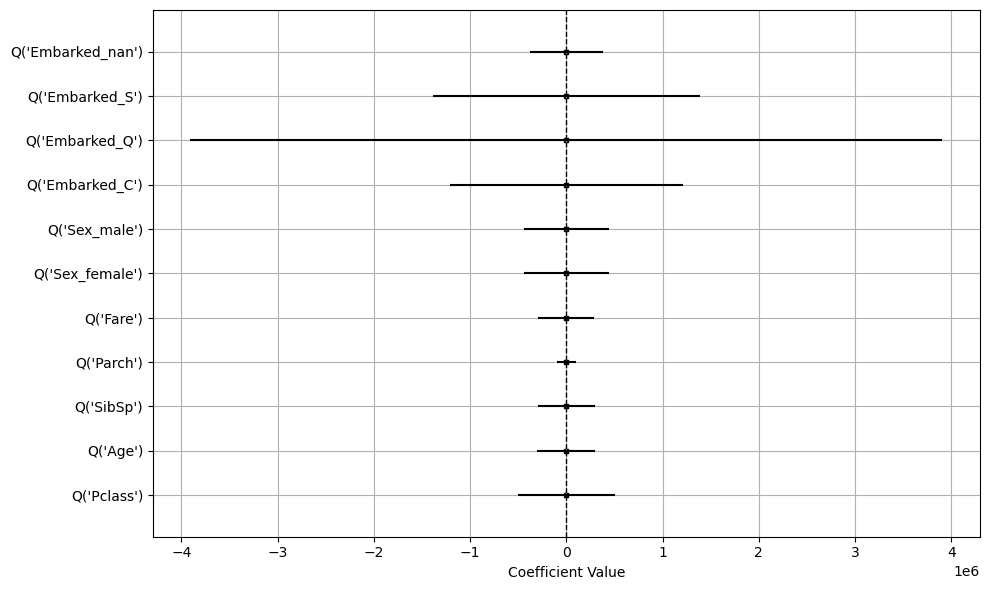

In [27]:
# Analyze coefficients of the logistic regression model
err_series = logistic.params - logistic.conf_int()[0]
coef_df = pd.DataFrame({
    'coef': pd.to_numeric(logistic.params.values[1:], errors='coerce'),
    'err': pd.to_numeric(err_series.values[1:], errors='coerce'),
    'varname': err_series.index.values[1:]
})

# Plot coefficient values with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(coef_df['varname'], coef_df['coef'], xerr=coef_df['err'], color='none', edgecolor=None)
ax.scatter(y=coef_df['varname'], x=coef_df['coef'], marker='s', s=10, color='black')
ax.axvline(x=0, linestyle='--', color='black', linewidth=1)

ax.set_xlabel('Coefficient Value')
ax.set_ylabel('')
ax.grid(True)

plt.tight_layout()
plt.show()